In [1]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))
    
fix_layout()

In [28]:
import sys

import numpy as np
import matplotlib.pyplot as plt
#from logs import enable_logging, logging 
from importlib import reload
import nnpde.functions.iterative_methods as im
from nnpde.functions import geometries

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

net = nn.Sequential(
    nn.Conv2d(1, 1, 3, padding=1, bias=False),
    nn.Conv2d(1, 1, 3, padding=1, bias=False),
    nn.Conv2d(1, 1, 3, padding=1, bias=False),
)


# Set the optimizer, you have to play with lr: if too big nan
optim = torch.optim.SGD(net.parameters(), lr = 1e-6)
#optim = torch.optim.Adam(net.parameters(), lr=1e-6)
#optim = torch.optim.ASGD(net.parameters())
# SGD seems much faster

for name, param in net.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[[[ 0.2061, -0.1765,  0.1110],
          [-0.1712,  0.0157,  0.2400],
          [-0.0562, -0.1324, -0.2765]]]], requires_grad=True)
1.weight Parameter containing:
tensor([[[[ 0.2790, -0.2787,  0.2971],
          [-0.2405,  0.2793, -0.2001],
          [-0.3074,  0.0802,  0.2241]]]], requires_grad=True)
2.weight Parameter containing:
tensor([[[[-0.1268,  0.0840,  0.2704],
          [-0.2398,  0.1048,  0.0607],
          [ 0.0276, -0.2108, -0.1389]]]], requires_grad=True)


New one based only on convolutions and pointwise tensor operations, see iterativeMethods.py

In [9]:
losses = []

In [21]:
reload(H)

<module 'nnpde.functions.helpers' from '/home/sam/proj/epfl/ml_pde_deep_learning/nnpde/nnpde/functions/helpers.py'>

In [29]:
# Define train dimension
N = 16

for _ in range(20):
    net.zero_grad()

    # Sample k
    k = np.random.randint(1, 20)
    
    B, B_idx = geometries.square_geometry(N)
    
    # Initialize f: we use a zero forcing term for training
    f = torch.zeros(1, 1, N, N)

    # Initialize solution vector randomly 
    initial_u = torch.randn(1, 1, N, N, requires_grad = True)
    
    # Compute ustar = ground_truth solution torch 
    ground_truth = im.jacobi_method(B_idx, B, f, initial_u = None, k = 1000)

    # Solve the same problem, at each iteration the only thing changing are the weights, which are optimized
    # TODO why though? wouldn't it make much more sense to train it more times on different problems? isn't this the same as oversampling each training sample?
    for _ in range(20):
        
        # Compute the solution with the updated weights
        u = im.H_method(net, B_idx, B, f, initial_u, k)
        
        # Define the loss, CHECK if it is correct wrt paper
        loss = F.mse_loss(ground_truth, u)
        
        """ TODO 
        spectral_radius = TODO
        regularization = 1e10
        if spectral_radius > 1
           loss += regularization
        """
        
        # Exit optimization 
        tol = 1e-6
        if loss.item() <= tol:
            break
            
        # Backpropagation
        loss.backward(retain_graph =  False)
        
        # SGD step
        optim.step()
        
        # Store lossses for visualization
        losses.append(loss.item())

for name, param in net.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[[[-0.0667, -0.2958, -0.2671],
          [-0.3381, -0.2351,  0.0652],
          [-0.4623, -0.2637, -0.5311]]]], requires_grad=True)
1.weight Parameter containing:
tensor([[[[ 0.5508, -0.0906,  0.5137],
          [ 0.1179,  0.4929,  0.0413],
          [ 0.1510,  0.3906,  0.4354]]]], requires_grad=True)
2.weight Parameter containing:
tensor([[[[-0.2676, -0.1153, -0.0838],
          [-0.5387, -0.1089, -0.2480],
          [-0.2616, -0.3902, -0.4272]]]], requires_grad=True)


Plot the losses

final loss is 0.09422984719276428


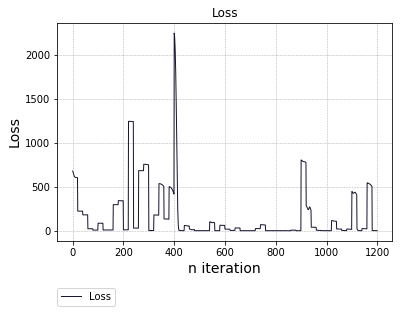

In [30]:
color_map = plt.get_cmap('cubehelix')
colors = color_map(np.linspace(0.1, 1, 10))

losses_fig = plt.figure()
n_iter = np.arange(np.shape(losses)[0])
plt.plot(n_iter, losses, color = colors[0], linewidth = 1, linestyle = "-", marker = "",  label='Loss')

plt.legend(bbox_to_anchor=(0., -0.3), loc=3, borderaxespad=0.)
plt.xlabel('n iteration', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss')
plt.grid(True, which = "both", linewidth = 0.5,  linestyle = "--")

print("final loss is {0}".format(losses[-1]))
#losses_fig.savefig('gridSearch.eps', bbox_inches='tight')

Test on a bigger grid

In [31]:
N = 50

B, B_idx = geometries.square_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = 1000)

tensor(0.0371, grad_fn=<SumBackward0>)


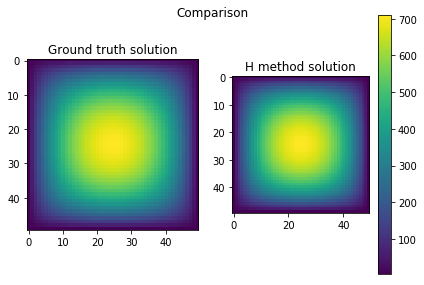

In [32]:
print(F.mse_loss(gtt, output))

Z_gtt = gtt.view(N,N).numpy() 
Z_output = output.detach().view(N, N).numpy()

fig, axes = plt.subplots(nrows = 1, ncols = 2)

fig.suptitle("Comparison")

im_gtt = axes[0].imshow(Z_gtt)
axes[0].set_title("Ground truth solution")

im_output = axes[1].imshow(Z_output)
axes[1].set_title("H method solution")

fig.colorbar(im_gtt)
fig.tight_layout()

plt.show()

Test on L-shape domain

In [36]:
B, B_idx = geometries.l_shaped_geometry(N)

# Set forcing term
f = torch.ones(1,1,N,N)*1.0

# Obtain solutions
gtt = im.jacobi_method(B_idx, B, f, torch.ones(1,1,N,N), k = 10000)
output = im.H_method(net, B_idx, B, f, torch.ones(1,1,N,N), k = 2000)

tensor(0.0022, grad_fn=<SumBackward0>)


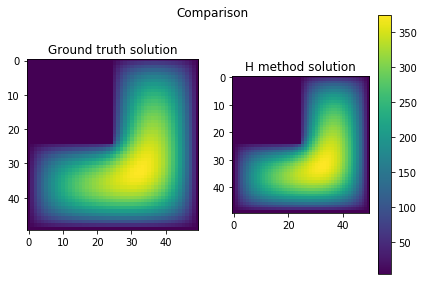

In [37]:
print(F.mse_loss(gtt, output))

Z_gtt = gtt.view(N,N).numpy() 
Z_output = output.detach().view(N, N).numpy()

fig, axes = plt.subplots(nrows = 1, ncols = 2)

fig.suptitle("Comparison")

im_gtt = axes[0].imshow(Z_gtt)
axes[0].set_title("Ground truth solution")

im_output = axes[1].imshow(Z_output)
axes[1].set_title("H method solution")

fig.colorbar(im_gtt)
fig.tight_layout()

plt.show()

Some way to compute the spectral radius maybe helpful. We need to build the matrix H and then compute it.
H is built from the weights. Here we consider only the case conv1

In [ ]:
import scipy as sp
from scipy.linalg import circulant

vector_H = np.zeros(N**2)
vector_H[0] = param[0, 0, 1, 1]
vector_H[1] = param[0, 0, 1, 2]
vector_H[N**2-1] = param[0, 0, 1, 0]

vector_H[N**2-N] = param[0, 0, 0, 1]
vector_H[N**2-N-1] = param[0, 0, 0, 0]
vector_H[N**2-N+1] = param[0, 0, 0, 2]

vector_H[N] = param[0, 0, 2, 1]
vector_H[N-1] = param[0, 0, 2, 0]
vector_H[N+1] = param[0, 0, 2, 2]

p = np.zeros([3,3])
for name, param in net.named_parameters():
    for i in range(3):
        for j in range(3):
            p[i,j] = param[0,0,i,j]

H = np.diag(np.ones(N**2)*p[1,1]) + np.diag(np.ones(N**2-1)*p[1,2], 1) + np.diag(np.ones(N**2-1)*p[1,0], -1) + np.diag(np.ones(N**2-N)*p[2,1], N) + np.diag(np.ones(N**2-N)*p[0,1], -N)



#H = np.transpose(circulant(vector_H))
np.shape(H)
#print(np.real(np.linalg.eigvals(T+H.dot(T)-H)))
Heq = T.numpy()+H.dot(T.numpy())-H
reg = 0.0
#spectral_radius = (np.max(np.real(np.linalg.eigvals(Heq))))

spectral_radius = np.max(np.real(np.fft.fft(vector_T))) + np.max(np.real(np.fft.fft(vector_H)))*np.max(np.real(np.fft.fft(vector_TI)))

In [ ]:
T_I = np.reshape(T.numpy()-I.numpy(), [N**2, N**2])
Tn = np.reshape(T.numpy(), [N**2, N**2])
print(np.max(np.abs(np.real(np.linalg.eigvals(Tn-H.dot(T_I))))))